# Installs

In [530]:
# !pip install numpy==1.19.5
# !pip install pandas==1.3.4
# !pip install statsmodels==0.13.2
# !pip install scikit-learn==1.0.2
# !pip install xgboost==1.5.2
# !pip install catboost==1.0.5
# !pip install deep-forest==0.1.5
# !pip install tensorflow==2.7.0
# !pip install keras-tuner --upgrade
# !pip install shap --upgrade

# Imports

In [531]:
from datetime import datetime, date, time
# import onetick.py as otp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from IPython.core.interactiveshell import InteractiveShell

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from statsmodels.tsa.seasonal import STL

from xgboost import XGBRegressor, DMatrix, cv as xgb_cv, callback
from catboost import CatBoostRegressor, Pool, cv as cat_cv, sum_models
from deepforest import CascadeForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.ensemble import StackingRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
import shap

# InteractiveShell.ast_node_interactivity = "all"
# pd.set_option('display.max_rows', 200)

# Loading data

## ETF

In [532]:
# db = 'NYSE_TAQ'
# tick_type = 'TRD'
# symbols = ['QQQ']
# start = otp.dt(2021, 4, 1, 9, 30)
# end = otp.dt(2022, 4, 1, 16, 0)
# bucket = 600
# timezone='EST5EDT'

# data = otp.DataSource(db = db, tick_type = tick_type, symbol = symbols, start = start, end = end, identify_input_ts=True)

# data = data.agg({'VOLUME': otp.agg.sum(data['SIZE']),
#                  'TICK_VOLUME': otp.agg.count()},
#                  group_by = ['TICKER'],
#                  bucket_interval = bucket)

# data['hhmm'] = data['Time'].dt.strftime(format='%H:%M')

# etf_df = otp.run(data, apply_times_daily=True, timezone=timezone)

In [533]:
# etf_df = etf_df.groupby(['Time', 'hhmm'], as_index=False)['VOLUME'].sum()
# etf_df = etf_df[(etf_df['Time'].dt.dayofweek!=5) & (etf_df['Time'].dt.dayofweek!=6)].reset_index(drop=True)
# etf_ts = etf_df.set_index('Time').copy(deep=True)

# etf_ts

In [534]:
# etf_ts.to_csv('./data/etf_nq.csv')

In [535]:
etf_ts = pd.read_csv('../data/etf_nq.csv').set_index('Time')
etf_ts

,hhmm,VOLUME
Time,,
2021-04-01 09:40:00,09:40,5787283
2021-04-01 09:50:00,09:50,3001767
2021-04-01 10:00:00,10:00,1523707
2021-04-01 10:10:00,10:10,3199697
2021-04-01 10:20:00,10:20,2662730
...,...,...
2022-04-01 15:20:00,15:20,1281702
2022-04-01 15:30:00,15:30,1013253
2022-04-01 15:40:00,15:40,1386788


## Futures

In [536]:
# db = 'CME'
# tick_type = 'TRD'
# symbols = ['NQ\H21', 'NQ\M21', r'NQ\U21', 'NQ\Z21', 'NQ\H22', 'NQ\M22'] #H M U Z
# start = otp.dt(2021, 4, 1, 9, 30)
# end = otp.dt(2022, 4, 1, 16, 0)
# bucket = 600
# timezone='EST5EDT'

# data = otp.DataSource(db = db, tick_type = tick_type, symbol = symbols, start = start, end = end, identify_input_ts=True)
# data['TICKER'] = data['SYMBOL_NAME']
# data = data.agg({'VOLUME': otp.agg.sum(data['SIZE']),
#                  'TICK_VOLUME': otp.agg.count()},
#                  group_by = ['TICKER'],
#                  bucket_interval = bucket)

# data['hhmm'] = data['Time'].dt.strftime(format='%H:%M')

# fut_df = otp.run(data, apply_times_daily=True, timezone=timezone)

In [537]:
# fut_df = fut_df.groupby(['Time', 'hhmm'], as_index=False)['VOLUME'].sum()
# fut_df = fut_df[(fut_df['Time'].dt.dayofweek!=5) & (fut_df['Time'].dt.dayofweek!=6)].reset_index(drop=True)
# fut_ts = fut_df.set_index('Time').copy(deep=True)

# fut_ts

In [538]:
# fut_ts.to_csv('./data/fut_nq.csv')

In [539]:
fut_ts = pd.read_csv('../data/fut_nq.csv').set_index('Time')
fut_ts

,hhmm,VOLUME
Time,,
2021-04-01 09:40:00,09:40,31967
2021-04-01 09:50:00,09:50,13194
2021-04-01 10:00:00,10:00,9774
2021-04-01 10:10:00,10:10,26026
2021-04-01 10:20:00,10:20,10889
...,...,...
2022-04-01 15:20:00,15:20,9723
2022-04-01 15:30:00,15:30,9506
2022-04-01 15:40:00,15:40,10394


## Options

In [540]:
# db = 'US_OPTIONS'
# tick_type = 'TRD'
# start = otp.dt(2021, 4, 1)
# end = otp.dt(2022, 4, 1)
# bucket = 600
# timezone='EST5EDT'

# data = otp.DataSource(db=db, tick_type=tick_type, start=start, end=end, identify_input_ts=True)
# data['Date'] = data['Time'].dt.date()

# volume_date = data.agg({'VOLUME': otp.agg.sum(data['SIZE'])}, group_by=['Date'])
# volume_10min = data.agg({'VOLUME': otp.agg.sum(data['SIZE'])}, bucket_interval = bucket)

# # all_symbols = otp.Symbols(db='US_OPTIONS', date=start, keep_db=True, pattern='QQQ   220302%')
# all_symbols = otp.Symbols(db='US_OPTIONS', start=start, end=end, keep_db=True, pattern='QQQ%')

# symbols_date = otp.funcs.merge([volume_date], symbols=all_symbols, identify_input_ts=True)

# most_traded_by_days = symbols_date.high('VOLUME', n=5, group_by=['Date'])
# most_traded_by_days = otp.run(most_traded_by_days, timezone=timezone)

# symbols = list(pd.unique(most_traded_by_days['SYMBOL_NAME']))
# symbols_10min = otp.funcs.merge([volume_10min], symbols=symbols, identify_input_ts=True)
# symbols_10min['hhmm'] = symbols_10min['Time'].dt.strftime(format='%H:%M')

# symbols_10min['Date'] = symbols_10min['Time'].dt.date()
# symbols_10min = symbols_10min.agg({'VOLUME': otp.agg.sum(symbols_10min['VOLUME'])}, group_by = ['Date', 'hhmm'])

# opt_df = otp.run(symbols_10min, timezone=timezone)
# opt_df

In [541]:
# opt_df['Time'] = pd.to_datetime(opt_df['Date'].astype(str) + ' ' + opt_df['hhmm'])
# opt_df = opt_df[(opt_df['Time'].dt.dayofweek!=5) & (opt_df['Time'].dt.dayofweek!=6)].reset_index(drop=True)
# opt_ts = opt_df.loc[(opt_df['Time'].dt.time > time(9, 30)) & (opt_df['Time'].dt.time <= time(16, 0))]
# opt_ts = opt_ts.drop('Date', axis=1).set_index('Time').copy(deep=True)
# opt_ts

In [542]:
# opt_ts.to_csv('./data/opt_nq.csv')

In [543]:
opt_ts = pd.read_csv('../data/opt_nq.csv').set_index('Time')
opt_ts

,hhmm,VOLUME
Time,,
2021-04-01 09:40:00,09:40,20914
2021-04-01 09:50:00,09:50,14998
2021-04-01 10:00:00,10:00,9644
2021-04-01 10:10:00,10:10,17938
2021-04-01 10:20:00,10:20,12092
...,...,...
2022-03-31 15:20:00,15:20,18724
2022-03-31 15:30:00,15:30,12523
2022-03-31 15:40:00,15:40,18835


## Join together

In [544]:
ts = fut_ts.join(etf_ts, lsuffix='_fut', rsuffix='_etf', how='inner')
ts = ts.join(opt_ts, how='inner')
ts = ts.rename(columns={'VOLUME':'VOLUME_opt'}).drop(['hhmm_fut','hhmm_etf'], axis=1)

columns = ['VOLUME_fut', 'VOLUME_etf', 'VOLUME_opt']

test_size = 0.1
val_size = 0.1

val_len = int(ts.shape[0]*val_size + 0.5)
test_len = int(ts.shape[0]*test_size + 0.5)
train_len = int(ts.shape[0] - val_len - test_len + 0.5)

train_indexes = list(range(train_len))
val_indexes = list(range(train_len, train_len+val_len))
test_indexes = list(range(train_len+val_len, train_len+val_len+test_len))

ts

,VOLUME_fut,VOLUME_etf,hhmm,VOLUME_opt
Time,,,,
2021-04-01 09:40:00,31967,5787283,09:40,20914
2021-04-01 09:50:00,13194,3001767,09:50,14998
2021-04-01 10:00:00,9774,1523707,10:00,9644
2021-04-01 10:10:00,26026,3199697,10:10,17938
2021-04-01 10:20:00,10889,2662730,10:20,12092
...,...,...,...,...
2022-03-31 15:20:00,8872,1283681,15:20,18724
2022-03-31 15:30:00,12924,1501646,15:30,12523
2022-03-31 15:40:00,16582,1970892,15:40,18835


# Data overview

<AxesSubplot:xlabel='Time'>

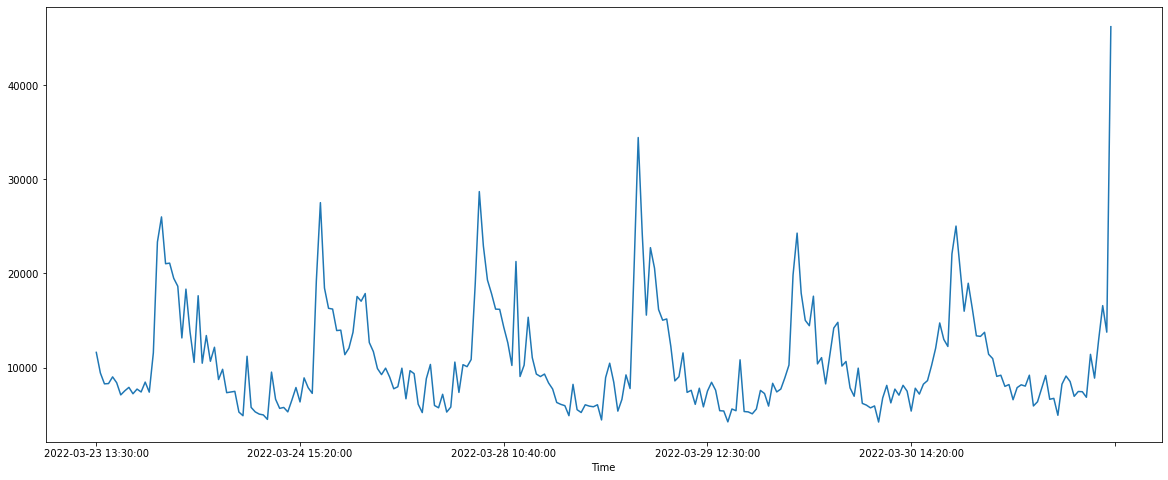

In [545]:
ts['VOLUME_fut'].iloc[-250:].plot(figsize=[20, 8])

## Autocorrelation

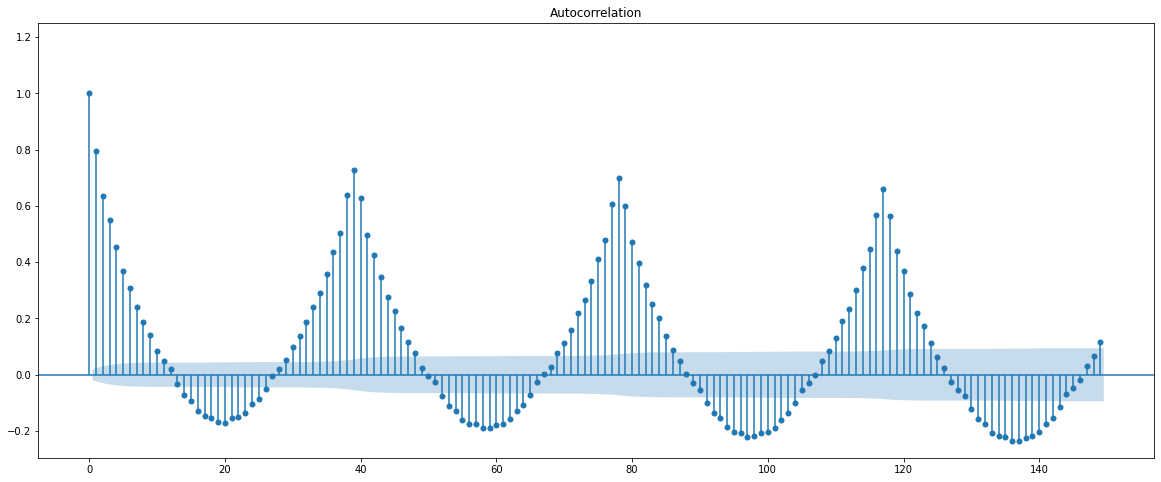

In [546]:
fig, ax = plt.subplots(figsize=(20, 8))
plt_pacf = plot_acf(ts['VOLUME_fut'], ax = ax, lags = np.arange(150), auto_ylims = True)

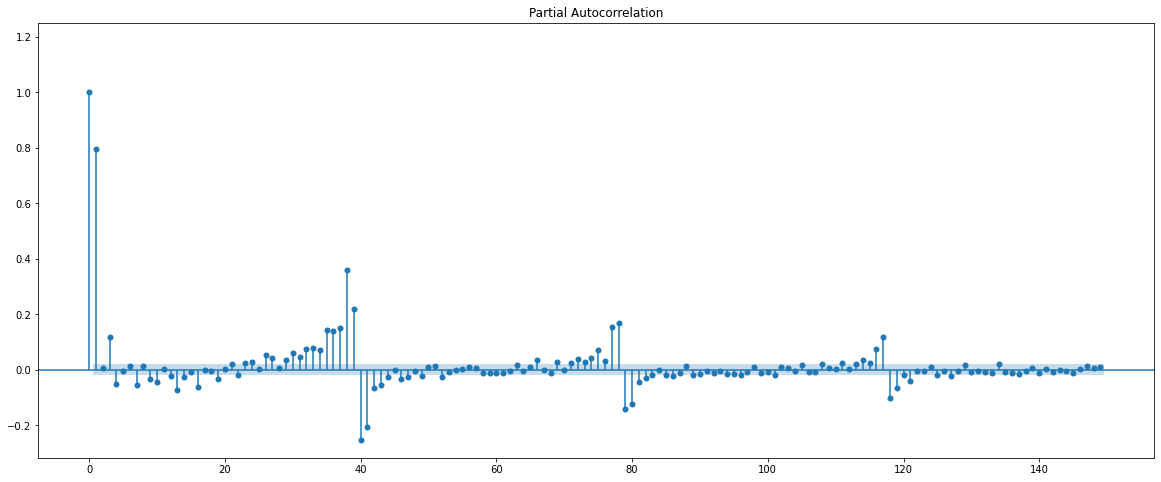

In [547]:
fig, ax = plt.subplots(figsize=(20, 8))
plt_pacf = plot_pacf(ts['VOLUME_fut'], ax = ax, lags = np.arange(150), auto_ylims = True, method='ywm')

# Preprocessing

## Remove strong outliers

In [548]:
std_num=4
for column in columns:
    mean = ts.iloc[train_indexes].mean(numeric_only=True)[column]
    std = ts.iloc[train_indexes].std(numeric_only=True)[column]
    up_border = mean + std_num * std
    down_border = mean - std_num * std
    ts[column] = ts[column].where(ts[column] <= up_border, up_border)
    ts[column] = ts[column].where(ts[column] >= down_border, down_border)

## Remove seasonality

### Intraday averaging

In [549]:
bins = 39
window_days = 10
ts[['VOLUME_fut_agg', 'VOLUME_etf_agg', 'VOLUME_opt_agg']] = np.NaN
all_hhmm = pd.unique(ts['hhmm'])

for i in range(0, ts.shape[0]-bins*(window_days+1)+1, 39):
    for hhmm in all_hhmm:
        hhmm_df = \
            ts.iloc[i:bins*window_days+i].loc[ts['hhmm']==hhmm]
        for column in columns:
            vol_agg = hhmm_df.loc[:,column].mean()
            ts.iloc[i+bins*window_days:i+bins*(window_days+1)].loc[ts['hhmm']==hhmm, f'{column}_agg'] = vol_agg


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


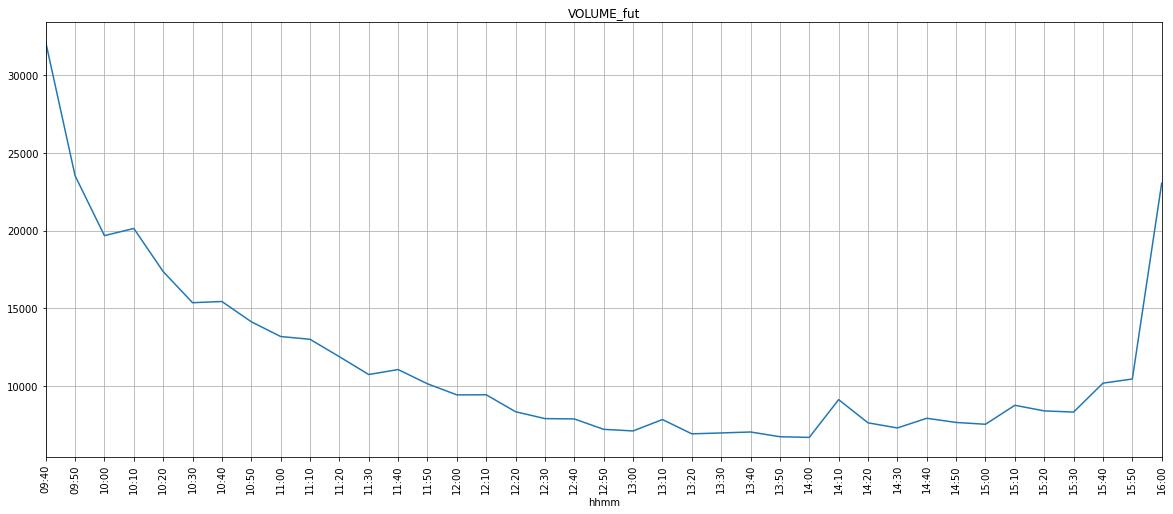

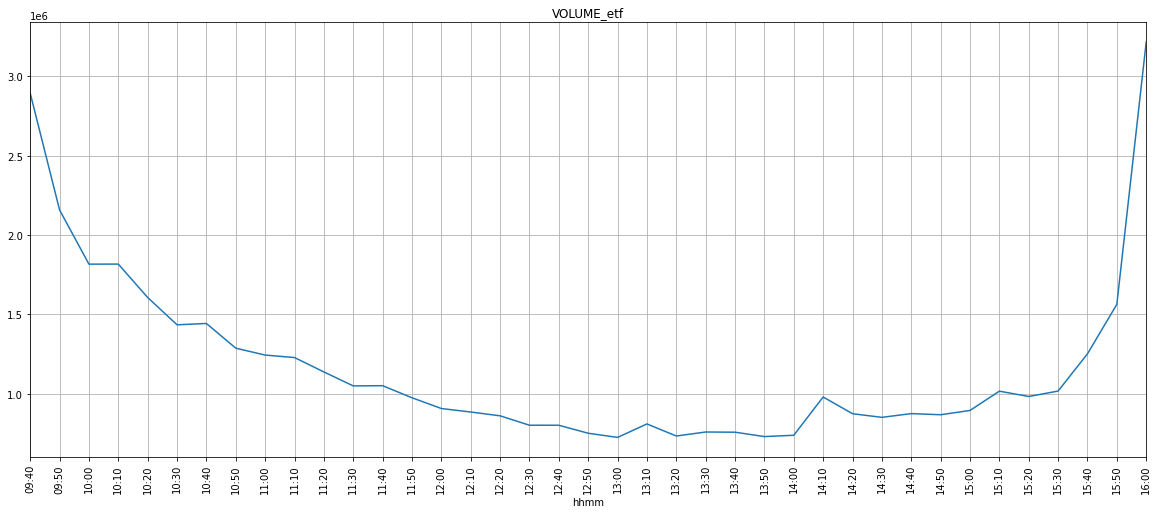

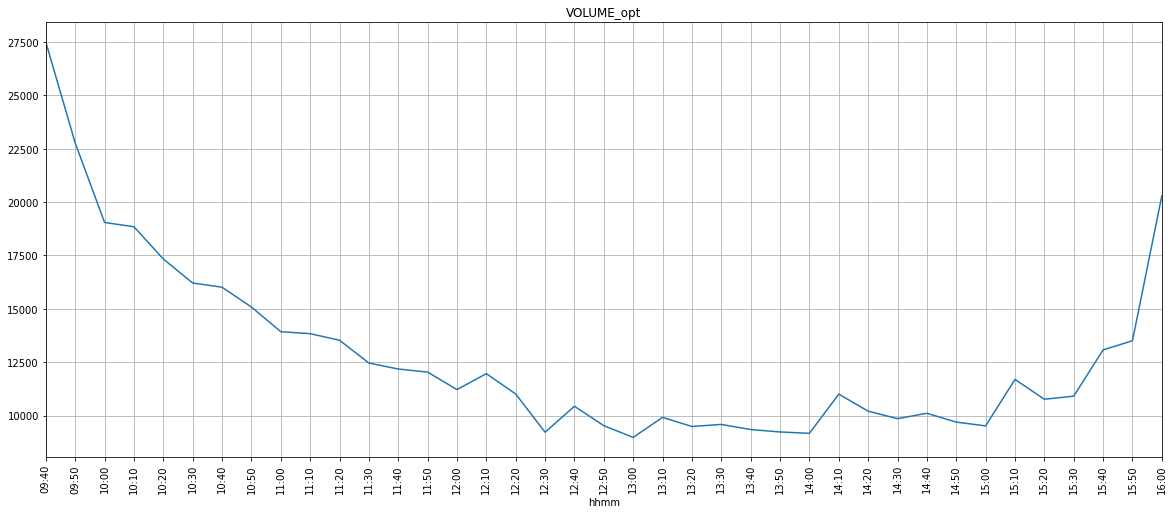

In [550]:
ts_agg = ts.groupby('hhmm').mean()

for column in columns:
    fig, ax = plt.subplots(figsize=(20, 8))
    ax = ts_agg[column].plot(ax=ax, title=column)
    ax.set_xticks(list(range(ts_agg.shape[0])), list(ts_agg.index), rotation='vertical')
    ax.grid()
    ax.set_xlim(0, ts_agg.shape[0]-1)

### Calculate: VOLUME-INTRADAY_AVERAGE

In [551]:
# ts_unseason = ts.join(ts_agg, on='hhmm', rsuffix='_agg').copy(deep=True)
ts_unseason = ts.copy(deep=True)

for column in columns:
    ts_unseason[column] = ts_unseason[column] - ts_unseason[f'{column}_agg']

ts_unseason.dropna(inplace=True)
ts_unseason

,VOLUME_fut,VOLUME_etf,hhmm,VOLUME_opt,VOLUME_fut_agg,VOLUME_etf_agg,VOLUME_opt_agg
Time,,,,,,,
2021-04-16 09:40:00,8573.700000,-235448.648856,09:40,-673.2,27796.3,2.251353e+06,20969.2
2021-04-16 09:50:00,4423.000000,-374200.200000,09:50,-574.2,18858.0,1.533303e+06,15068.2
2021-04-16 10:00:00,4546.400000,-145072.100000,10:00,1841.4,15123.6,1.276655e+06,12918.6
2021-04-16 10:10:00,4222.400000,659952.900000,10:10,4611.8,16648.6,1.344359e+06,13768.2
2021-04-16 10:20:00,1612.500000,640154.800000,10:20,13992.6,13596.5,1.213769e+06,11981.4
...,...,...,...,...,...,...,...
2022-03-31 15:20:00,362.400000,-46278.000000,15:20,5125.3,8509.6,1.329959e+06,13598.7
2022-03-31 15:30:00,3813.600000,-247522.500000,15:30,-2346.5,9110.4,1.749168e+06,14869.5
2022-03-31 15:40:00,6665.500000,321426.700000,15:40,5309.8,9916.5,1.649465e+06,13525.2


<AxesSubplot:xlabel='Time'>

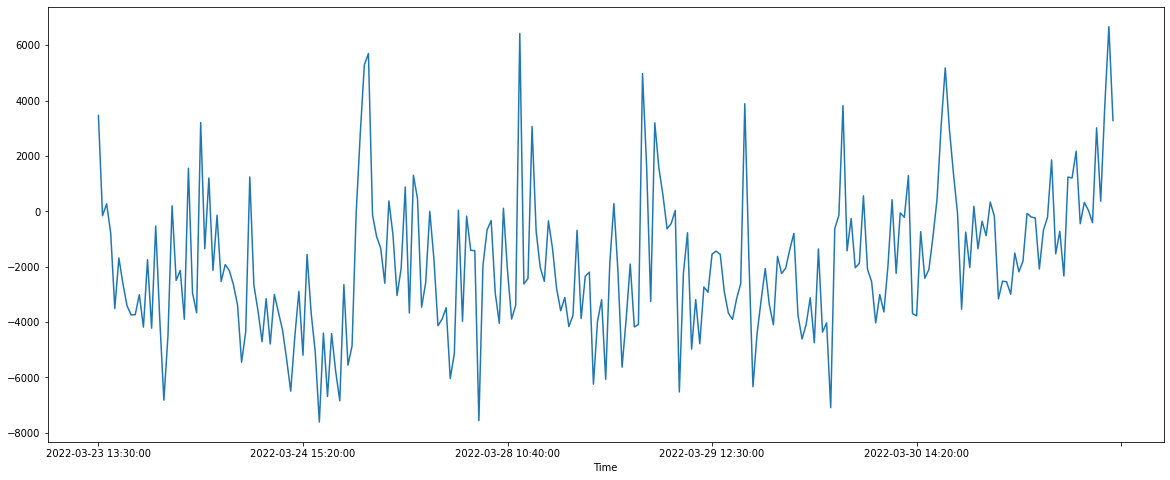

In [552]:
ts_unseason['VOLUME_fut'].iloc[-250:-1].plot(figsize=[20, 8])

# Features

## Partial autocorrelation

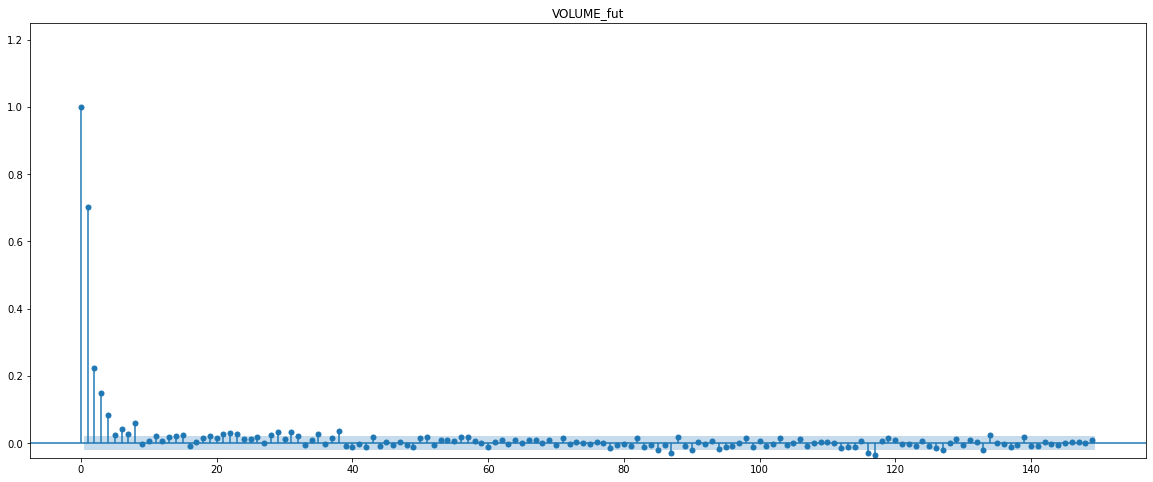

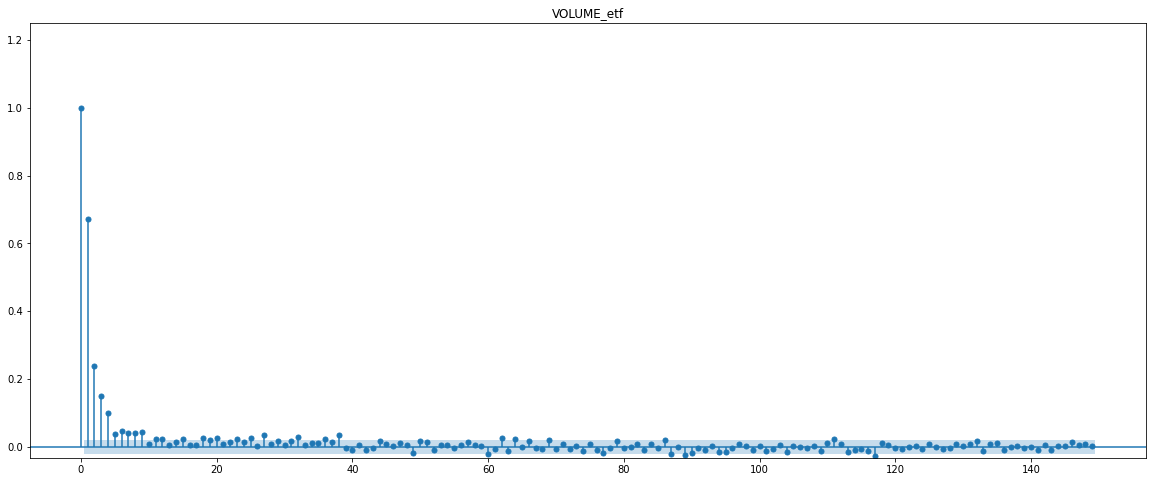

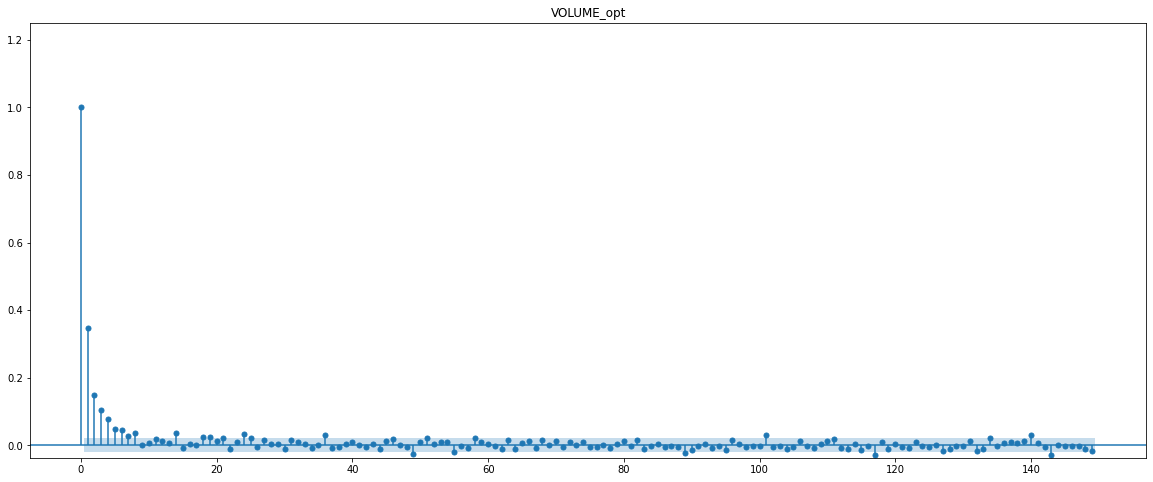

In [553]:
for column in columns:
    fig, ax = plt.subplots(figsize=(20, 8))
    plt_pacf = plot_pacf(ts_unseason[column], ax = ax, lags = np.arange(150), auto_ylims = True, method='ywm', title=column)

## Features

### Add lags

In [554]:
df = ts_unseason[columns+['hhmm', 'VOLUME_fut_agg']].copy(deep=True)

periods = [1, 2, 3, 4, 38, 39, 40, 41]
target = ['VOLUME_fut']
features_columns = []
for column in columns:
    for lag in periods:
        feature_col_name = f'{column}_lag_{lag}'
        df[feature_col_name] = df.shift(lag)[column]
        features_columns.append(feature_col_name)

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,VOLUME_fut,VOLUME_etf,VOLUME_opt,hhmm,VOLUME_fut_agg,VOLUME_fut_lag_1,VOLUME_fut_lag_2,VOLUME_fut_lag_3,VOLUME_fut_lag_4,VOLUME_fut_lag_38,...,VOLUME_etf_lag_40,VOLUME_etf_lag_41,VOLUME_opt_lag_1,VOLUME_opt_lag_2,VOLUME_opt_lag_3,VOLUME_opt_lag_4,VOLUME_opt_lag_38,VOLUME_opt_lag_39,VOLUME_opt_lag_40,VOLUME_opt_lag_41
0,-3081.200000,-528308.700000,-7496.2,10:00,16113.2,-1177.7,2398.4,-543.6,1780.0,4222.4,...,-374200.2,-2.354486e+05,-7378.800000,-9809.400000,-5264.000000,6431.200000,4611.8,1841.4,-574.200000,-673.200000
1,13073.900000,483166.400000,1712.6,10:10,16133.1,-3081.2,-1177.7,2398.4,-543.6,1612.5,...,-145072.1,-3.742002e+05,-7496.200000,-7378.800000,-9809.400000,-5264.000000,13992.6,4611.8,1841.400000,-574.200000
2,10982.500000,692931.400000,4989.4,10:20,14028.5,13073.9,-3081.2,-1177.7,2398.4,1420.8,...,659952.9,-1.450721e+05,1712.600000,-7496.200000,-7378.800000,-9809.400000,10881.7,13992.6,4611.800000,1841.400000
3,3282.600000,-157142.000000,-313.1,10:30,13140.4,10982.5,13073.9,-3081.2,-1177.7,2872.2,...,640154.8,6.599529e+05,4989.400000,1712.600000,-7496.200000,-7378.800000,403.0,10881.7,13992.600000,4611.800000
4,2298.200000,146334.500000,-8997.1,10:40,12841.8,3282.6,10982.5,13073.9,-3081.2,2866.3,...,1642437.6,6.401548e+05,-313.100000,4989.400000,1712.600000,-7496.200000,13437.4,403.0,10881.700000,13992.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9431,362.400000,-46278.000000,5125.3,15:20,8509.6,3013.1,-410.3,32.6,320.9,5177.8,...,1754317.8,-1.872123e+05,6057.549855,117.300000,-3666.200000,-3184.700000,-3073.3,6462.4,46974.601455,4423.700000
9432,3813.600000,-247522.500000,-2346.5,15:30,9110.4,362.4,3013.1,-410.3,32.6,3000.9,...,668821.6,1.754318e+06,5125.300000,6057.549855,117.300000,-3666.200000,-3833.2,-3073.3,6462.400000,46974.601455
9433,6665.500000,321426.700000,5309.8,15:40,9916.5,3813.6,362.4,3013.1,-410.3,1374.1,...,784014.6,6.688216e+05,-2346.500000,5125.300000,6057.549855,117.300000,-509.2,-3833.2,-3073.300000,6462.400000
9434,3278.600000,715577.300000,346.6,15:50,10482.4,6665.5,3813.6,362.4,3013.1,-65.3,...,66086.7,7.840146e+05,5309.800000,-2346.500000,5125.300000,6057.549855,-10710.8,-509.2,-3833.200000,-3073.300000


### Features importance

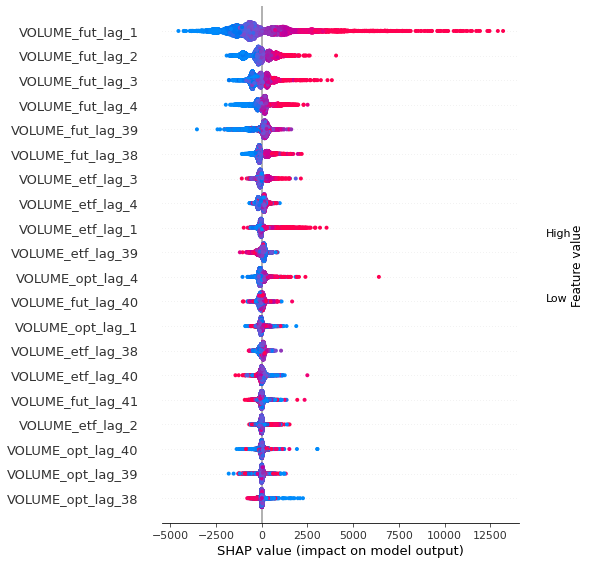

Index(['VOLUME_fut_lag_1', 'VOLUME_fut_lag_2', 'VOLUME_fut_lag_3',
       'VOLUME_fut_lag_4', 'VOLUME_fut_lag_39', 'VOLUME_fut_lag_38',
       'VOLUME_etf_lag_3', 'VOLUME_etf_lag_4', 'VOLUME_etf_lag_1',
       'VOLUME_etf_lag_39'],
      dtype='object')

In [555]:
cat = CatBoostRegressor(iterations=100)
cat.fit(df[features_columns], df[target], verbose=0, plot=False)

explainer = shap.TreeExplainer(cat)
shap_values=explainer.shap_values(Pool(df[features_columns], df[target]))
shap.summary_plot(shap_values, df[features_columns])

top_features = pd.DataFrame(shap_values, columns=df[features_columns].columns).apply(lambda x: abs(x)).sum().sort_values(ascending=False)[:10].index
top_features

# Splitting

In [556]:
val_size /= (1 - test_size)
x_train, x_test, y_train, y_test = train_test_split(df[top_features], df[target], test_size=test_size, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size, shuffle=False)

In [557]:
x_train

,VOLUME_fut_lag_1,VOLUME_fut_lag_2,VOLUME_fut_lag_3,VOLUME_fut_lag_4,VOLUME_fut_lag_39,VOLUME_fut_lag_38,VOLUME_etf_lag_3,VOLUME_etf_lag_4,VOLUME_etf_lag_1,VOLUME_etf_lag_39
0,-1177.7,2398.4,-543.6,1780.0,4546.4,4222.4,-385914.7,219870.7,-244167.8,-145072.1
1,-3081.2,-1177.7,2398.4,-543.6,4222.4,1612.5,-18524.2,-385914.7,-528308.7,659952.9
2,13073.9,-3081.2,-1177.7,2398.4,1612.5,1420.8,-244167.8,-18524.2,483166.4,640154.8
3,10982.5,13073.9,-3081.2,-1177.7,1420.8,2872.2,-528308.7,-244167.8,692931.4,1642437.6
4,3282.6,10982.5,13073.9,-3081.2,2872.2,2866.3,483166.4,-528308.7,-157142.0,-115315.3
...,...,...,...,...,...,...,...,...,...,...
7543,3243.4,6761.1,4107.4,3631.9,-4162.2,-6080.0,1585976.0,1202706.2,1732325.4,-351820.7
7544,4644.6,3243.4,6761.1,4107.4,-6080.0,-462.1,1521037.0,1585976.0,1549837.2,-626983.4
7545,3226.6,4644.6,3243.4,6761.1,-462.1,3528.7,1732325.4,1521037.0,1423745.3,1746107.6
7546,1730.4,3226.6,4644.6,3243.4,3528.7,2665.4,1549837.2,1732325.4,719059.8,484697.9


In [558]:
y_train

,VOLUME_fut
0,-3081.2
1,13073.9
2,10982.5
3,3282.6
4,2298.2
...,...
7543,4644.6
7544,3226.6
7545,1730.4
7546,-1281.2


In [559]:
x_train.index, x_val.index, x_test.index

(Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
             ...
             7538, 7539, 7540, 7541, 7542, 7543, 7544, 7545, 7546, 7547],
            dtype='int64', length=7548),
 Int64Index([7548, 7549, 7550, 7551, 7552, 7553, 7554, 7555, 7556, 7557,
             ...
             8482, 8483, 8484, 8485, 8486, 8487, 8488, 8489, 8490, 8491],
            dtype='int64', length=944),
 Int64Index([8492, 8493, 8494, 8495, 8496, 8497, 8498, 8499, 8500, 8501,
             ...
             9426, 9427, 9428, 9429, 9430, 9431, 9432, 9433, 9434, 9435],
            dtype='int64', length=944))

# Scaling

In [560]:
scaler = MinMaxScaler()
scaler.fit(x_train)

x_train = pd.DataFrame(data=scaler.transform(x_train), index=x_train.index, columns=x_train.columns)
x_val = pd.DataFrame(data=scaler.transform(x_val), index=x_val.index, columns=x_val.columns)
x_test = pd.DataFrame(data=scaler.transform(x_test), index=x_test.index, columns=x_test.columns)

In [561]:
x_train

,VOLUME_fut_lag_1,VOLUME_fut_lag_2,VOLUME_fut_lag_3,VOLUME_fut_lag_4,VOLUME_fut_lag_39,VOLUME_fut_lag_38,VOLUME_etf_lag_3,VOLUME_etf_lag_4,VOLUME_etf_lag_1,VOLUME_etf_lag_39
0,0.377665,0.439428,0.388617,0.428748,0.476526,0.470931,0.351559,0.441940,0.372707,0.387492
1,0.344790,0.377665,0.439428,0.388617,0.470931,0.425855,0.406372,0.351559,0.330315,0.507599
2,0.623805,0.344790,0.377665,0.439428,0.425855,0.422544,0.372707,0.406372,0.481223,0.504645
3,0.587685,0.623805,0.344790,0.377665,0.422544,0.447611,0.330315,0.372707,0.512519,0.654182
4,0.454699,0.587685,0.623805,0.344790,0.447611,0.447509,0.481223,0.330315,0.385691,0.391932
...,...,...,...,...,...,...,...,...,...,...
7543,0.454022,0.514777,0.468944,0.460732,0.326120,0.292998,0.645758,0.588575,0.667593,0.356646
7544,0.478222,0.454022,0.514777,0.468944,0.292998,0.390025,0.636069,0.645758,0.640366,0.315593
7545,0.453732,0.478222,0.454022,0.514777,0.390025,0.458950,0.667593,0.636069,0.621554,0.669649
7546,0.427891,0.453732,0.478222,0.454022,0.458950,0.444040,0.640366,0.667593,0.516417,0.481451


# Training - Prediction

## Baseline model (current value = previous value)

MAE/StdDev 39.88564024395437
R2, MAE, MAPE:
0.6742123801242895 2629.502874402369 0.22409273331868287


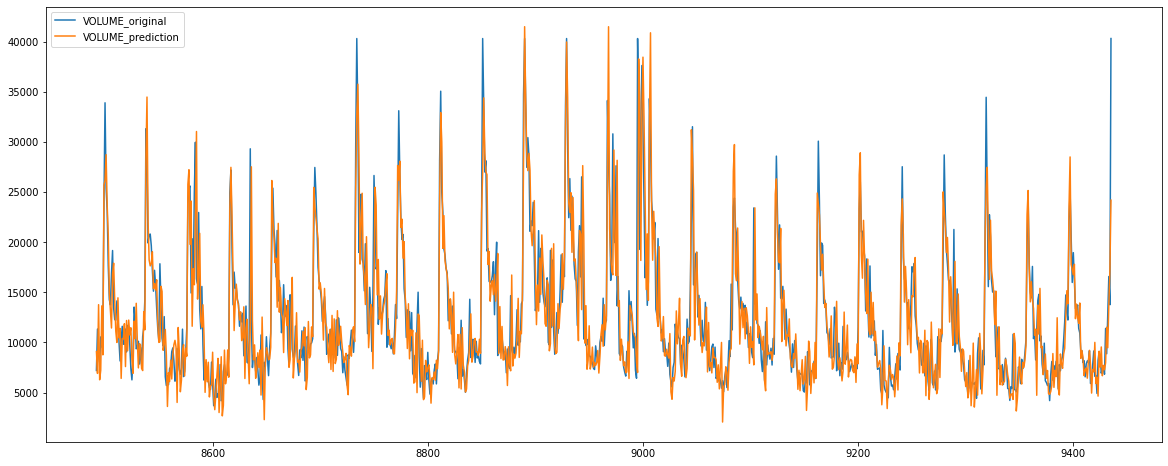

In [580]:
tdf = df[['VOLUME_fut', 'VOLUME_fut_agg']].copy(deep=True)
tdf['prediction'] = tdf['VOLUME_fut'].shift(1)
tdf.dropna(inplace = True)
tdf_test = tdf.loc[x_test.index]

tdf_test['VOLUME_prediction'] = tdf_test['prediction'] + tdf_test['VOLUME_fut_agg']
tdf_test['VOLUME_original'] = tdf_test['VOLUME_fut'] + tdf_test['VOLUME_fut_agg']

tdf_test['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

std_orig = tdf_test.std(numeric_only=True)['VOLUME_original']
r2_baseline = r2_score(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mae_baseline = mean_absolute_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mape_baseline = mean_absolute_percentage_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])

print('MAE/StdDev', mae_baseline/std_orig*100)
print('R2, MAE, MAPE:')
print(r2_baseline, mae_baseline, mape_baseline)

## XGBoost

In [562]:
# xgb = XGBRegressor(nthread=4, n_estimators=300, max_depth=1, min_child_weight=6, learning_rate=0.08)
# xgb.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose=0)

class SaveBestModel(callback.TrainingCallback):
    def __init__(self, cvboosters):
        self._cvboosters = cvboosters

    def after_training(self, model):
        self._cvboosters[:] = [cvpack.bst for cvpack in model.cvfolds]
        return model


param_grid = {'max_depth': [1], 'min_child_weight': [1], 'learning_rate': [0.09],
              'models_num': [10], 'early_stopping_rounds': [30]}

for params in ParameterGrid(param_grid):
    
    tscv = TimeSeriesSplit(n_splits=params['models_num'])
    cv_index_list = []
    for cv_train_index, cv_val_index in tscv.split(pd.concat([x_train, x_val])):
        cv_index_list.append((cv_train_index, cv_val_index))
    
    cv_models = []
    xgb_params = {
              # 'nthread': 4,
              # 'n_estimators': 500,
              'max_depth': params['max_depth'],
              'min_child_weight': params['min_child_weight'],
              'learning_rate': params['learning_rate']}

    data_dmatrix = DMatrix(data=pd.concat([x_train, x_val]), label=pd.concat([y_train, y_val]))

    cv_results = xgb_cv(dtrain=data_dmatrix, params=xgb_params, folds=cv_index_list, num_boost_round=500, 
                        early_stopping_rounds=params['early_stopping_rounds'], metrics="mae", as_pandas=True, 
                        seed=0, shuffle=False, callbacks=[SaveBestModel(cv_models)])
    print(params)
    print(cv_results['test-mae-mean'].min())

{'early_stopping_rounds': 30, 'learning_rate': 0.09, 'max_depth': 1, 'min_child_weight': 1, 'models_num': 10}
2133.9319459000003


MAE/StdDev 33.99887656501631
R2, MAE, MAPE:
0.7553321192506746 2241.411773945699 0.19385791204954927


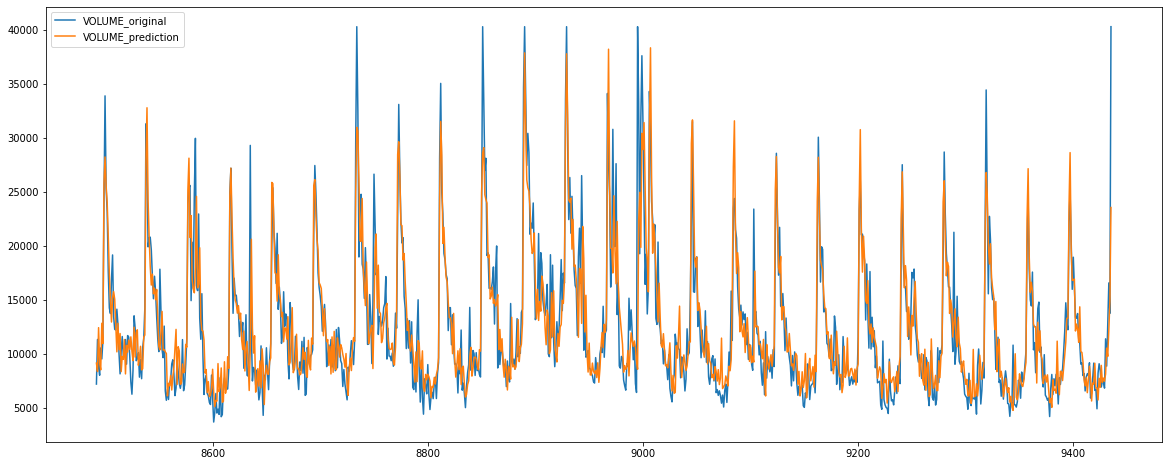

In [581]:
# prediction_xgb = pd.DataFrame(xgb.predict(x_test), index=x_test.index, columns=['prediction'])

prediction_xgb = pd.DataFrame(pd.concat([pd.DataFrame(xgb.predict(DMatrix(x_test)), index=x_test.index) for xgb in cv_models], 
                                        axis=1).mean(axis=1), columns=['prediction'])

tdf_test = prediction_xgb.join(df)[['prediction','VOLUME_fut_agg', 'VOLUME_fut']].copy(deep=True)
tdf_test['VOLUME_prediction'] = tdf_test['prediction'] + tdf_test['VOLUME_fut_agg']
tdf_test['VOLUME_original'] = tdf_test['VOLUME_fut'] + tdf_test['VOLUME_fut_agg']

tdf_test['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

std_orig = tdf_test.std(numeric_only=True)['VOLUME_original']
r2_xgb = r2_score(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mae_xgb = mean_absolute_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mape_xgb = mean_absolute_percentage_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])

print('MAE/StdDev', mae_xgb/std_orig*100)
print('R2, MAE, MAPE:')
print(r2_xgb, mae_xgb, mape_xgb)

<AxesSubplot:>

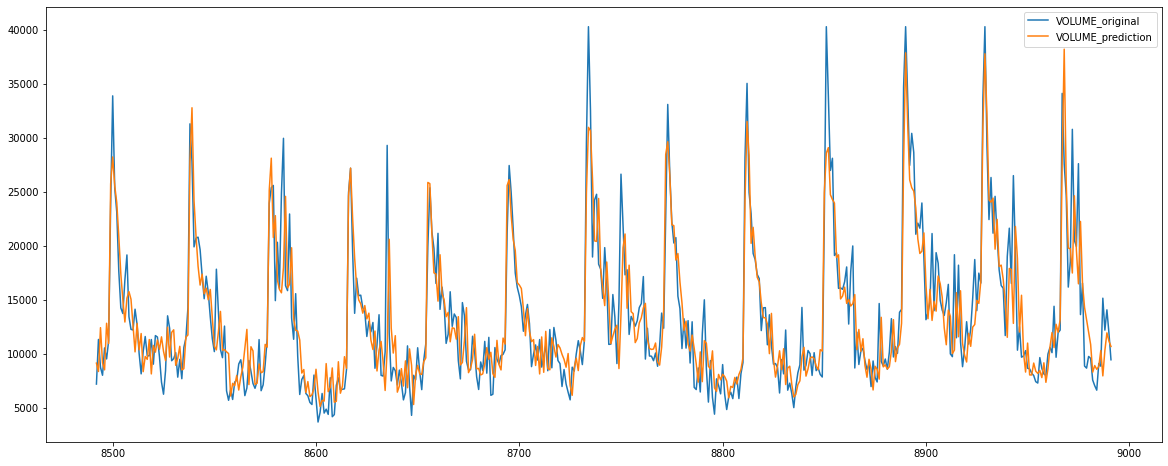

In [564]:
tdf_test.iloc[:500]['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test.iloc[:500]['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

## CatBoost

In [565]:
# cat = CatBoostRegressor(learning_rate=0.08, depth=4, l2_leaf_reg=1, iterations=1000)
# cat.fit(x_train, y_train, eval_set=Pool(x_val, y_val), use_best_model=True, verbose=0, plot=True)

param_grid = {'depth': [2], 'l2_leaf_reg': [3], 'learning_rate': [0.09], 'models_num': [10], 'early_stopping_rounds': [30]}
for params in ParameterGrid(param_grid):
    models_num = params['models_num']
    cv_dataset = Pool(data=pd.concat([x_train, x_val]), label=pd.concat([y_train, y_val]))

    cat_params = {"iterations": 500,
                  "depth": params['depth'],
                  "l2_leaf_reg": params['l2_leaf_reg'],
                  "learning_rate": params['learning_rate'],
                  "loss_function": "MAE",
                  "custom_metric": 'R2',
                  # "eval_metric": 'BalancedAccuracy',
                  "use_best_model": True,
                  "verbose": False}

    res = cat_cv(cv_dataset,
                 cat_params,
                 fold_count=models_num,
                 shuffle=False,
                 early_stopping_rounds=params['early_stopping_rounds'],
                 type='TimeSeries ',
                 return_models=True,
                 plot = False,
                 logging_level='Silent')
    print(params)
    print(res[0]['test-MAE-mean'].min())

{'depth': 2, 'early_stopping_rounds': 30, 'l2_leaf_reg': 3, 'learning_rate': 0.09, 'models_num': 10}
2088.1647847045137


MAE/StdDev 33.65511733759505
R2, MAE, MAPE:
0.7488874567921686 2218.7490845397406 0.18454571873868245


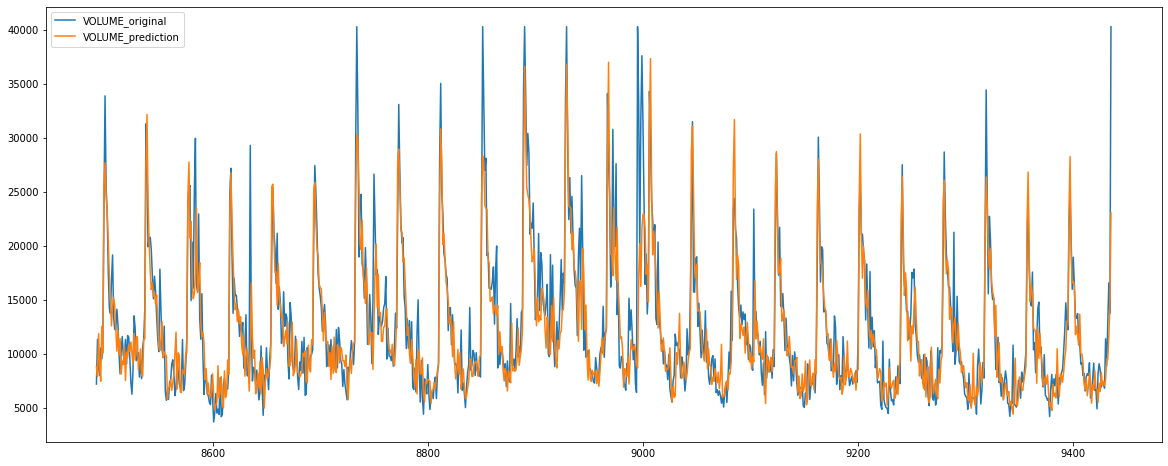

In [582]:
cat = sum_models(res[1], [1/models_num]*models_num)
    
prediction_cat = pd.DataFrame(cat.predict(x_test), index=x_test.index, columns=['prediction'])

tdf_test = prediction_cat.join(df)[['prediction','VOLUME_fut_agg', 'VOLUME_fut']].copy(deep=True)
tdf_test['VOLUME_prediction'] = tdf_test['prediction'] + tdf_test['VOLUME_fut_agg']
tdf_test['VOLUME_original'] = tdf_test['VOLUME_fut'] + tdf_test['VOLUME_fut_agg']

tdf_test['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

std_orig = tdf_test.std(numeric_only=True)['VOLUME_original']
r2_cat = r2_score(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mae_cat = mean_absolute_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mape_cat = mean_absolute_percentage_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])

print('MAE/StdDev', mae_cat/std_orig*100)
print('R2, MAE, MAPE:')
print(r2_cat, mae_cat, mape_cat)

<AxesSubplot:>

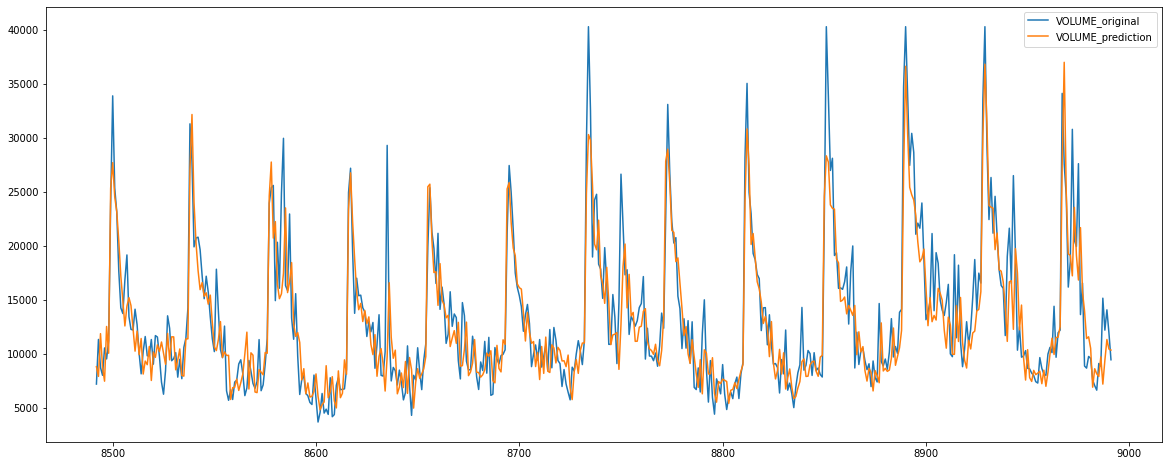

In [567]:
tdf_test.iloc[:500]['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test.iloc[:500]['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

## DNN

In [568]:
class TSCVTuner(kt.engine.tuner.Tuner):
    def on_search_begin(self):
        super().on_search_begin()
        self.results = {}
        self.results['trials'] = []
        self.results['models'] = []
        self.results['metrics'] = []
        self.results['params'] = []

    def run_trial(self, trial, x, y, **kwargs):
        hp = trial.hyperparameters
        tscv = TimeSeriesSplit(5)
        val_losses = []
        for train_indices, test_indices in tscv.split(x):
            x_train_cv, x_test_cv = x.loc[train_indices], x.loc[test_indices]
            y_train_cv, y_test_cv = y.loc[train_indices], y.loc[test_indices]
            model = self.hypermodel.build(hp)
            history = model.fit(x_train_cv, y_train_cv, validation_data=(x_test_cv, y_test_cv), **kwargs)
            metric = model.evaluate(x_test_cv, y_test_cv, verbose=0)
            val_losses.append(metric)
            self.save_model(trial.trial_id, model, metric, str(hp.get_config()['values']))

        print(hp.get_config()['values'], 'metric value:', np.mean(val_losses))
        self.oracle.update_trial(trial.trial_id, {'val_loss': np.mean(val_losses)})

        return {'val_loss': np.mean(val_losses)}

    def save_model(self, trial_id, model, metric, params, step=0):
        # if params not in self.results.keys():
        #     self.results[params] = {}
        #     self.results[params]['models'] = []
        #     self.results[params]['metrics'] = []
        # self.results[params]['models'].append(model)
        # self.results[params]['metrics'].append(metric)
        self.results['trials'].append(trial_id)
        self.results['models'].append(model)
        self.results['metrics'].append(metric)
        self.results['params'].append(params)



class DNN(kt.HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Choice('units1', [28, 32]), activation = hp.Choice('activation1', ['relu'])))
        # model.add(Dropout(hp.Choice('drop1', [0.0, 0.1, 0.5])))
        model.add(Dense(units=hp.Choice('units2', [28, 32]), activation = hp.Choice('activation2', ['relu'])))
        # model.add(Dropout(hp.Choice('drop2', [0.0, 0.1, 0.5])))
        model.add(Dense(1))

        model.compile(loss = 'mean_squared_error', optimizer = 'RMSprop')
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            epochs=hp.Choice('epochs', [1024]),
            batch_size=hp.Choice('batch_size', [32]),
            shuffle=False,
            verbose=0,
            **kwargs
        )

tuner = TSCVTuner(
    oracle=kt.oracles.RandomSearch(
        objective='val_loss',
        max_trials=10),
    hypermodel=DNN(),
    directory='./dnn_checkpoints/',
    overwrite=True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=32, restore_best_weights=True)
tuner.search(pd.concat([x_train, x_val]), pd.concat([y_train, y_val]), batch_size=32, epochs=1024, shuffle=False, verbose=0, callbacks=[early_stopping])

{'units1': 32, 'activation1': 'relu', 'units2': 32, 'activation2': 'relu'} metric value: 11679126.9
{'units1': 28, 'activation1': 'relu', 'units2': 28, 'activation2': 'relu'} metric value: 13496802.6
{'units1': 32, 'activation1': 'relu', 'units2': 28, 'activation2': 'relu'} metric value: 11628546.9
{'units1': 28, 'activation1': 'relu', 'units2': 32, 'activation2': 'relu'} metric value: 11664567.3
INFO:tensorflow:Oracle triggered exit


In [569]:
min_index = pd.DataFrame(tuner.results).groupby(['trials']).mean().idxmin()
dnn_models = pd.DataFrame(tuner.results).set_index('trials').loc[min_index['metrics']]['models'].values

In [570]:
# # to-do: combine tuning with cross validation
# class DNN(kt.HyperModel):
#     def build(self, hp):
#         from tensorflow.keras.models import Sequential
#         from tensorflow.keras.layers import Dense, Dropout
#
#         model = Sequential()
#         model.add(Dense(units=hp.Choice('units1', [24, 28, 32]), activation = hp.Choice('activation1', ['relu'])))
#         # model.add(Dropout(hp.Choice('drop1', [0.0, 0.1, 0.5])))
#         model.add(Dense(units=hp.Choice('units2', [12, 16, 20, 24, 28, 32]), activation = hp.Choice('activation2', ['relu'])))
#         # model.add(Dropout(hp.Choice('drop2', [0.0, 0.1, 0.5])))
#         model.add(Dense(1))
#
#         model.compile(loss = 'mean_squared_error', optimizer = 'RMSprop')
#         return model
#
#     def fit(self, hp, model, *args, **kwargs):
#         return model.fit(
#             *args,
#             epochs=hp.Choice('epochs', [1024]),
#             batch_size=hp.Choice('batch_size', [32]),
#             shuffle=False,
#             verbose=0,
#             **kwargs
#         )
#
# tuner = kt.RandomSearch(
#     DNN(),
#     objective='val_loss',
#     max_trials = 18,
#     directory='./dnn_checkpoints/',
#     overwrite=True,
# )
# early_stopping = EarlyStopping(monitor='val_loss', patience=32, restore_best_weights=True)
# tuner.search(x_train, y_train, validation_data=(x_val, y_val), callbacks=[early_stopping])

In [571]:
# tuner.results_summary()

In [572]:
# mae_dnn = []
# for i in range(1,11):
#     dnn_models = tuner.get_best_models(num_models=i)
#
#     prediction_dnn = pd.DataFrame(pd.concat([pd.DataFrame(dnn.predict(x_val), index=x_val.index) for dnn in dnn_models], axis=1).mean(axis=1), columns=['prediction'])
#
#     tdf_val = prediction_dnn.join(df)[['prediction','VOLUME_fut_agg', 'VOLUME_fut']].copy(deep=True)
#     tdf_val['VOLUME_prediction'] = tdf_val['prediction'] + tdf_val['VOLUME_fut_agg']
#     tdf_val['VOLUME_original'] = tdf_val['VOLUME_fut'] + tdf_val['VOLUME_fut_agg']
#
#     mae_dnn.append(mean_absolute_error(tdf_val['VOLUME_original'], tdf_val['VOLUME_prediction']))
# dnn_models = tuner.get_best_models(num_models=np.argmin(mae_dnn)+1)

MAE/StdDev 34.69269134171115
R2, MAE, MAPE:
0.748109880925593 2287.1522444123466 0.20228667600745665


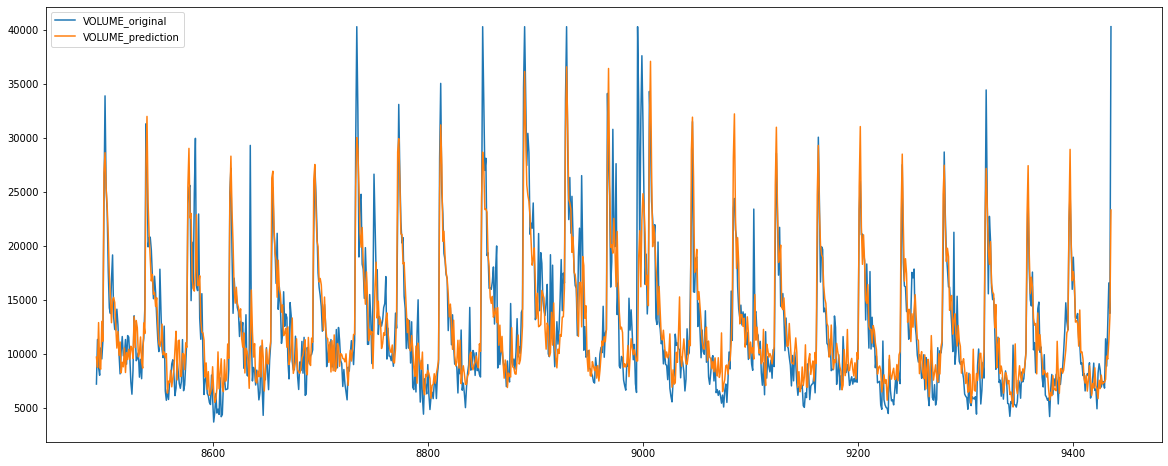

In [583]:
prediction_dnn = pd.DataFrame(pd.concat([pd.DataFrame(dnn.predict(x_test), index=x_test.index) for dnn in dnn_models], axis=1).mean(axis=1), columns=['prediction'])

tdf_test = prediction_dnn.join(df)[['prediction','VOLUME_fut_agg', 'VOLUME_fut']].copy(deep=True)
tdf_test['VOLUME_prediction'] = tdf_test['prediction'] + tdf_test['VOLUME_fut_agg']
tdf_test['VOLUME_original'] = tdf_test['VOLUME_fut'] + tdf_test['VOLUME_fut_agg']

tdf_test['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

std_orig = tdf_test.std(numeric_only=True)['VOLUME_original']
r2_dnn = r2_score(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mae_dnn = mean_absolute_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mape_dnn = mean_absolute_percentage_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])

print('MAE/StdDev', mae_dnn/std_orig*100)
print('R2, MAE, MAPE:')
print(r2_dnn, mae_dnn, mape_dnn)

<AxesSubplot:>

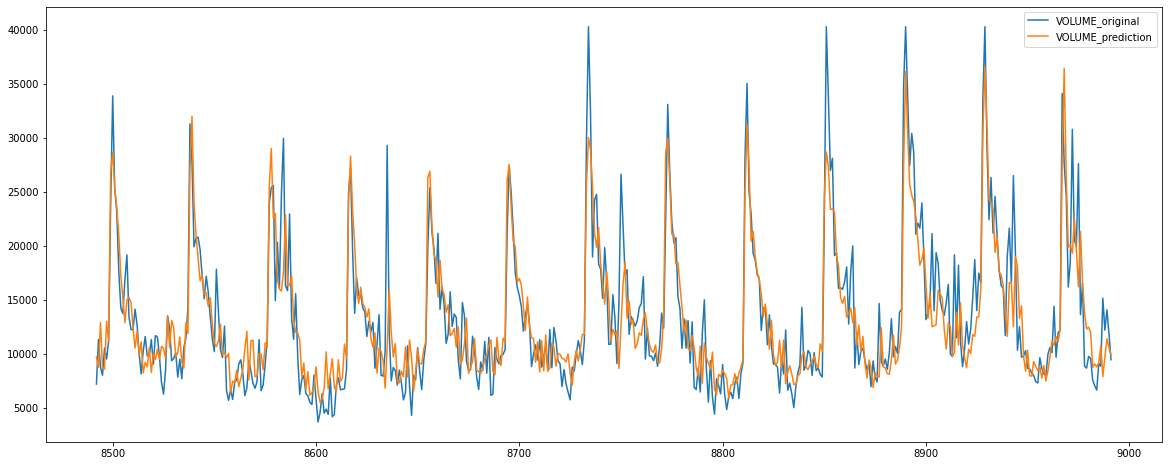

In [574]:
tdf_test.iloc[:500]['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test.iloc[:500]['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

## Deep Forest (Cascade Forest)

In [575]:
# ccd = CascadeForestRegressor(n_jobs=8, n_estimators=3, n_trees=300, max_layers=15)
# ccd.fit(pd.concat([x_train, x_val]).values, np.ravel(pd.concat([y_train, y_val]).values))

iters=1
param_grid = {'n_estimators': [3], 'n_trees': [300], 'max_layers': [5]}
for params in ParameterGrid(param_grid):
    r2_ccd, mae_ccd, mape_ccd = 0, 0, 0
    for j in range(iters):
        ccd = CascadeForestRegressor(n_jobs=8, n_estimators=params['n_estimators'], n_trees=params['n_trees'], 
                                     max_layers=params['max_layers'], random_state=0, verbose=0)
        ccd.fit(x_train.values, np.ravel(y_train.values))

        prediction_ccd = pd.DataFrame(ccd.predict(x_val), index=x_val.index, columns=['prediction'])

        tdf_val = prediction_ccd.join(df)[['prediction','VOLUME_fut_agg', 'VOLUME_fut']].copy(deep=True)
        tdf_val['VOLUME_prediction'] = tdf_val['prediction'] + tdf_val['VOLUME_fut_agg']
        tdf_val['VOLUME_original'] = tdf_val['VOLUME_fut'] + tdf_val['VOLUME_fut_agg']

        r2_ccd += r2_score(tdf_val['VOLUME_original'], tdf_val['VOLUME_prediction'])
        mae_ccd += mean_absolute_error(tdf_val['VOLUME_original'], tdf_val['VOLUME_prediction'])
        mape_ccd += mean_absolute_percentage_error(tdf_val['VOLUME_original'], tdf_val['VOLUME_prediction'])

    r2_ccd /= iters
    mae_ccd /=iters
    mape_ccd /= iters
    print(params)
    print('R2, MAE, MAPE:')
    print(r2_ccd, mae_ccd, mape_ccd)

{'max_layers': 5, 'n_estimators': 3, 'n_trees': 300}
R2, MAE, MAPE:
0.7879258739760517 2370.422286379712 0.19160473959153845


MAE/StdDev 34.66372355677843
R2, MAE, MAPE:
0.7492026561149827 2285.242512657265 0.1981865437390656


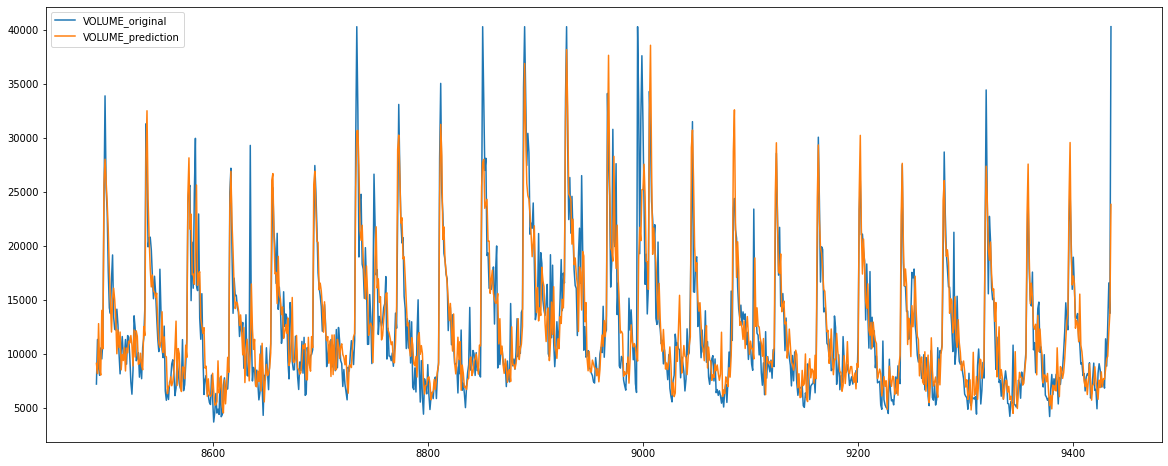

In [584]:
prediction_ccd = pd.DataFrame(ccd.predict(x_test), index=x_test.index, columns=['prediction'])

tdf_test = prediction_ccd.join(df)[['prediction','VOLUME_fut_agg', 'VOLUME_fut']].copy(deep=True)
tdf_test['VOLUME_prediction'] = tdf_test['prediction'] + tdf_test['VOLUME_fut_agg']
tdf_test['VOLUME_original'] = tdf_test['VOLUME_fut'] + tdf_test['VOLUME_fut_agg']

tdf_test['VOLUME_original'].plot(figsize=[20, 8], legend=True)
tdf_test['VOLUME_prediction'].plot(figsize=[20, 8], legend=True)

std_orig = tdf_test.std(numeric_only=True)['VOLUME_original']
r2_ccd = r2_score(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mae_ccd = mean_absolute_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])
mape_ccd = mean_absolute_percentage_error(tdf_test['VOLUME_original'], tdf_test['VOLUME_prediction'])

print('MAE/StdDev', mae_ccd/std_orig*100)
print('R2, MAE, MAPE:')
print(r2_ccd, mae_ccd, mape_ccd)

## Totals

In [585]:
print('Baseline:', r2_baseline, mae_baseline, mape_baseline)
print('XGBoost:', r2_xgb, mae_xgb, mape_xgb)
print('CatBoost:', r2_cat, mae_cat, mape_cat)
print('DNN:', r2_dnn, mae_dnn, mape_dnn)
print('Cascade Forest:', r2_ccd, mae_ccd, mape_ccd)

Baseline: 0.6742123801242895 2629.502874402369 0.22409273331868287
XGBoost: 0.7553321192506746 2241.411773945699 0.19385791204954927
CatBoost: 0.7488874567921686 2218.7490845397406 0.18454571873868245
DNN: 0.748109880925593 2287.1522444123466 0.20228667600745665
Cascade Forest: 0.7492026561149827 2285.242512657265 0.1981865437390656
